I would recommende fasi.ai NLP course for every NLP starters: https://www.fast.ai/2019/07/08/fastai-nlp/

This notebook is based on https://github.com/fastai/course-nlp/blob/master/review-nlp-transfer.ipynb

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [2]:
from fastai import *
from fastai.text import *

In [3]:
path = "/kaggle/input/nlp-getting-started"

df_train = pd.read_csv(os.path.join(path,'train.csv'))
df_test = pd.read_csv(os.path.join(path,'test.csv'))

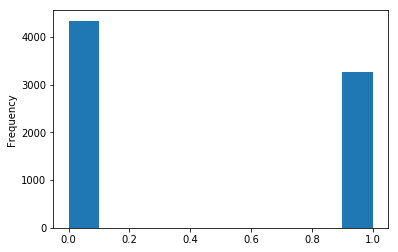

In [4]:
df_train.target.plot.hist() # quite a balance dataset

In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
df_train.head()

df_train.drop(['id','keyword','location'],axis = 1,inplace = True)
df_test_ = df_test.copy().drop(['id','keyword','location'],axis = 1)

In [7]:
df_test_['target'] = 0
df_test_.head()

,text,target
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",0
2,"there is a forest fire at spot pond, geese are...",0
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,0


In [8]:
valid_ix = np.random.choice(np.arange(len(df_train)),round(len(df_train)*0.2),replace = False)
train_ix = np.asarray(list(set(np.arange(len(df_train))) - set(valid_ix)))
assert(df_train.shape[0] == train_ix.shape[0]+valid_ix.shape[0])

In [9]:
bs = 32

swap the column so that it matches the format in fast.ai, where by default the first column is the label, the second is the text.

In [10]:
df_tr = df_train.iloc[train_ix,[1,0]]
df_val = df_train.iloc[valid_ix,[1,0]]
df_te = df_test_.iloc[:,[1,0]]

In [11]:
data_lm = TextLMDataBunch.from_df(path,train_df = df_tr,valid_df = df_val,
                                 )
data_clas = TextClasDataBunch.from_df(path,train_df = df_tr,valid_df = df_val,
                                 vocab=data_lm.train_ds.vocab, bs=bs,
                                     test_df = df_te)

In [12]:
data_lm.show_batch()

idx,text
0,orders in xxmaj california xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk xxunk xxmaj colorado xxmaj springs areas xxbos i 'm on top of the hill and i can see a fire in
1,# xxunk https : / / t.co / xxunk xxbos ' xxmaj remembering that you are going to die is the best way i know to avoid the trap of thinking you have something to lose . ' xxup ûò xxmaj steve xxmaj jobs xxbos xxmaj aftershock https : / / t.co / xxunk xxbos xxmaj aftershock back to school kick off was great . i want to thank everyone
2,/ / t.co / xxunk xxmaj xxunk xxmaj attack to xxmaj xxunk xxmaj humans http : / / t.co / xxunk xxbos : xxunk : : xxmaj xxunk 3 : : xxmaj xxunk xxmaj annihilation : : http : / / t.co / xxunk via @youtube xxbos xxup u.s xxmaj national xxmaj park xxmaj services xxmaj tonto xxmaj national xxmaj forest : xxmaj stop the xxmaj annihilation of the xxmaj
3,t.co / xxunk xxbos xxmaj vote for # xxmaj directioners vs # xxmaj queens in the 5th round of the xxunk # xxunk http : / / t.co / xxmaj xxunk xxbos xxmaj but if you build an army of 100 dogs and their leader is a lion all dogs will fight like a lion . xxbos ' xxmaj show xxmaj me a xxmaj hero ' : xxup tv xxmaj
4,xxmaj now xxmaj demand ûïhatchet control?û http : / / t.co / xxunk xxbos xxunk not everyone can see xxunk is xxmaj xxunk that is xxmaj all she can ever xxunk xxunk an attack dog 4 a hate group xxup gop xxbos xxmaj heart disease prevention : xxmaj what about xxunk smoke ? http : / / t.co / xxunk xxbos xxmaj attack on xxmaj titan game on xxup ps


Take a look a the tokenizer

In [13]:
x,y = next(iter(data_lm.train_dl))
example = x[:15,:15].cpu()
texts = pd.DataFrame([data_lm.train_ds.vocab.textify(l).split(' ') for l in example])
texts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,the,woods,...,xxbos,xxmaj,there,'s,an,emergency,evacuation,happening,now,in,the,building,None,None
1,for,making,it,possible,.,xxmaj,what,a,great,night,.,xxbos,xxmaj,people,who,None,None
2,salt,xxmaj,river,xxmaj,wild,xxmaj,horse,...,https,:,/,/,t.co,/,xxunk,None,None
3,review,http,:,/,/,t.co,/,xxunk,http,:,/,/,t.co,/,xxunk,None,None
4,xxmaj,xxunk,yay,!,xxmaj,ca,n't,wait,for,2016,xxbos,[,xxunk,],xxmaj,None,None
5,wake,of,anthrax,lab,mishaps,http,:,/,/,t.co,/,xxunk,via,@usatoday,xxbos,None,None
6,i,was,bleeding,n,shit,xxbos,xxunk,xxmaj,yes,i,'m,a,bleeding,heart,xxunk,None,None
7,'s,bloody,awful,as,well,xxunk,xxx,xxbos,i,ca,n't,bloody,wait,!,!,None,None
8,problem,in,this,game,body,bagging,niggas,#,xxunk,xxbos,i,was,body,xxmaj,bagging,None,None
9,forever,the,last,city,bombed,with,a,nuclear,weapon,.,',#,xxunk,xxbos,xxmaj,None,None


In [14]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.set_device(0)

In [15]:
opath = '/kaggle/working'

In [16]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5,path = opath)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.590240,3.716148,0.387078,00:03


In [17]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.711925,3.270358,0.431002,00:04
1,3.355482,3.005420,0.468700,00:04
2,2.968844,2.932171,0.481275,00:04
3,2.624769,2.928576,0.486384,00:04
4,2.381097,2.932316,0.485913,00:04


Because we fine-tune the model on the tweets about disaster, the result is pretty readable if you start off the sentence with something like

In [18]:
learn.predict("There is an earthquake", n_words=15)

'There is an earthquake nearby . i think the whole real area is awful . The earthquake could'

In [19]:
learn.predict("Huge fire", n_words=15)

'Huge fire in Northern California http : / / t.co / books http : /'

In [20]:
learn.predict("I love my gf", n_words=15)

'I love my gf the girl love him all that night ? i hated reporting this so bad but'

In [21]:
learn.save('ft')
learn.save_encoder('ft_enc')

In [22]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn.load_encoder(os.path.join(opath,'models','ft_enc'))

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6090 items)
x: TextList
xxbos xxmaj our xxmaj deeds are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj xxunk us all,xxbos xxmaj forest fire near xxmaj la xxmaj xxunk xxmaj xxunk . xxmaj canada,xxbos xxmaj all residents asked to ' shelter in place ' are being xxunk by officers . xxmaj no other evacuation or shelter in place orders are expected,xxbos xxunk people receive # wildfires evacuation orders in xxmaj california,xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires
y: CategoryList
1,1,1,1,1
Path: /kaggle/input/nlp-getting-started;

Valid: LabelList (1523 items)
x: TextList
xxbos xxmaj christian xxmaj attacked by xxmaj muslims at the xxmaj temple xxmaj mount after xxmaj waving xxmaj israeli xxmaj flag via xxmaj pamela xxmaj geller - ... http : / / t.co / xxunk g,xxbos if they kill off xxmaj xxunk i 'm rioting # xxmaj em

In [23]:
data_clas.show_batch()

text,target
xxbos _ \n xxrep 5 ? xxup retweet \n xxrep 7 ? \n xxrep 5 ? xxup follow xxup all xxup who xxup rt \n xxrep 7 ? \n xxrep 5 ? xxup followback \n xxrep 7 ? \n xxrep 5 ? xxup gain xxup with \n xxrep 7 ? \n xxrep 5 ? xxup follow ? xxunk # xxup xxunk,0
xxbos xxup info xxup r. xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup wnd : xxunk / 5 . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup xxunk . xxup tmp : 10 . xxup xxunk : xxunk .,0
xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0
xxbos xxmaj xxunk xxmaj hot xxmaj deals # xxunk > > http : / / t.co / xxunk xxunk xxup 27w xxup xxunk xxup xxunk xxup led xxmaj work xxmaj light xxup flood xxmaj lamp xxmaj xxunk xxmaj truck xxup suv xxup utv xxup aû _ http : / / t.co / xxunk,0
xxbos xxmaj morgan xxmaj silver xxmaj dollar xxunk p xxup xxunk xxmaj gem xxmaj bu xxup xxunk xxmaj blazing xxup ms xxrep 6 + xxmaj xxunk xxmaj rare xxmaj proof xxmaj like ! - xxmaj full reû _ http : / / t.co / xxunk http : / / t.co / xxunk,0


In [24]:
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.507727,0.467512,0.783979,00:03


In [25]:
learn.unfreeze()
learn.fit_one_cycle(3,slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.481363,0.513870,0.792515,00:08
1,0.448689,0.434063,0.810900,00:07
2,0.306059,0.435390,0.814839,00:07


## NB

By default, `get_preds` returns `probabilities` and `true_labels`, not `predicted_labels`. So use `np.argmax(probs,axis=1)` to get the predicted labels

In [26]:
valid_probs,valid_y = learn.get_preds(ds_type = DatasetType.Valid,ordered = True)

In [27]:
valid_preds = np.argmax(valid_probs,1)

In [28]:
from sklearn.metrics import *

In [29]:
accuracy_score(valid_y,valid_preds)

0.81483913328956

In [30]:
print(learn.predict('Huge fire near the Leceister Square but it is fake'))
learn.predict('Huge fire near the Leceister Square')[0]

(Category 1, tensor(1), tensor([0.0470, 0.9530]))


Category 1

In [31]:
test_probs,_ = learn.get_preds(ds_type = DatasetType.Test,ordered = True)

In [32]:
test_preds = np.argmax(test_probs.numpy(),1)
print(f'{test_preds.sum()} postives in {test_preds.shape[0]}')

1272 postives in 3263


In [33]:
sample_submission = pd.read_csv(os.path.join(path,'sample_submission.csv'))

In [34]:
sample_submission['target'] = test_preds

In [35]:
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [36]:
sample_submission.to_csv('sub_1.csv',index=False)